# Quantum Error Correction

## Three bit effective qubits
The quantum analog to the classical three bit replication code 
$$
\begin{align}
a \vert 0 \rangle + b\vert 1\rangle \mapsto~
&~~CX_{13}CX_{12}\big( a \vert 0 \rangle + b\vert 1\rangle \big)\vert 00\rangle \\
&= CX_{13}\big( a \vert 00 \rangle + b\vert 11\rangle \big)\vert 0\rangle \\
&= a \vert 000\rangle + b\vert 111\rangle  
\end{align}
$$
yields the effective qubit state $a \vert 000\rangle + b\vert 111\rangle$. 


## Bit errors
If transmission of the three bit effective qubit state is subject to bit wise binary symmetric channel noise with via the Kraus operator $E_{p,\text{bit}}$ such that an $n$-qubit state's density operators $\rho$ are modified as
$$
E_{p,\text{bit}}(\rho) = (1-p)\rho + p X\rho X 
$$
then error correction can be done with 
$$
{\cal E}_{\text{corr}} = P_0 + \sum_i X_i P_i
$$
where $X_i$ is Pauli X applied to the $i$th qubit and
$$
\begin{align}
P_0 = \vert 000 \rangle \langle  000 \vert + \vert 111 \rangle \langle 111\vert ,\\
P_1 = \vert 100 \rangle \langle  100 \vert + \vert 011 \rangle \langle 011\vert ,\\
P_0 = \vert 010 \rangle \langle  010 \vert + \vert 101 \rangle \langle 101\vert, \\
P_0 = \vert 001 \rangle \langle  001 \vert + \vert 110 \rangle \langle 110\vert \,.\\
\end{align}
$$


The probability of a 2 bit error is the same as in classical 3 bit repetition code. Two qubit errors are not corrected. 

The matrix of ${\cal E}_{\text{corr}}$ is calculated below. 

In [1]:
import numpy as np
import pennylane as qml

first_kets = np.array([[0,0,0],[1,0,0],[0,1,0],[0,0,1]])
second_kets = np.array([(ket + 1)%2 for ket in first_kets])

Ps = np.array([np.zeros((8,8)) for _ in range(4)])
for i in range(4):
    first_index  = np.ravel_multi_index(first_kets[i], [2]*3)
    second_index = np.ravel_multi_index(second_kets[i],[2]*3)
    Ps[i,first_index,first_index] = 1
    Ps[i,second_index,second_index] = 1

X = np.array([[0,1],[1,0]])
I = np.eye(2)
Xs = [np.eye(8) ,
      np.kron(np.kron(X,I),I),
      np.kron(np.kron(I,X),I),
      np.kron(np.kron(I,I),X)
     ]

E = sum([ Xs[i]@Ps[i] for i in range(4)])
# E = qml.QubitUnitary(E, wires =range(3))
E # The fluent reader can see here that E is the right matrix. 

array([[1., 1., 1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 1., 1., 1.]])

Below are checks that corrupted qubits are corrected. The three qubit state $\vert 001\rangle$ should be corrected to the state $\vert 000\rangle$. The latter, in the computation basis, has components [1,0,....,0].

In [2]:
corrupted_logical_qubit = [0,0,1]
corrupted_state = np.zeros(8) # Initializing
corrupted_state[np.ravel_multi_index(corrupted_logical_qubit,[2]*3)] = 1 # one non-zero component 
E = sum( [ Xs[i]@Ps[i] for i in range(4)])
E@corrupted_state


array([1., 0., 0., 0., 0., 0., 0., 0.])

This matrix is equal to that of to $MCX_{120}CX_{02}CX_{01}$, as seen below. 

In [20]:
# Not working for me 
mat1 = (qml.CNOT(wires = [0,1])@qml.I(wires=[2])).matrix()
mat2 = (qml.CNOT(wires = [0,2])@qml.I(wires=[1])).matrix()
mat3 = (qml.Toffoli(wires = [1,2,0])).matrix()
mat3,mat2,mat1

(array([[1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0]]),
 array([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.]]),
 array([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.]]))

## Phase flip

For correcting a phase flip (which is a flip by $Z$, analogous to how a bit flip is a flip by $X$)
further encode with $H^{\otimes 3}$ to get 
$$
\begin{align}
a \vert 0 \rangle + b\vert 1\rangle \mapsto~
&~~H^{\otimes 3} CX_{13}CX_{12}\big( a \vert 0 \rangle + b\vert 1\rangle \big)\vert 00\rangle \\
&= H^{\otimes 3} \big(a\vert 00 0\rangle + b\vert 111\rangle\big) \\ 
&=  a\vert +++ \rangle + b\vert ---\rangle \\ 
\end{align}
$$

In transmission, a phase flip may occur, e.g in the first component giving 
$$
a\vert -++ \rangle + b\vert +--\rangle\big) \\ 
$$
This can be corrected by applying $H^3$ to get 
$$
a\vert 100 \rangle + b\vert 011\rangle\big) \\ 
$$
and then applying the bit error correction via ${\cal E}_{\text{corr}}$. 

### Shor's Algorithm

Shor's algorithm simultaneously applies bit flip and phase flip corrections by increasing the number of ancilla qubits to 8, so the system has 9 qubits.  

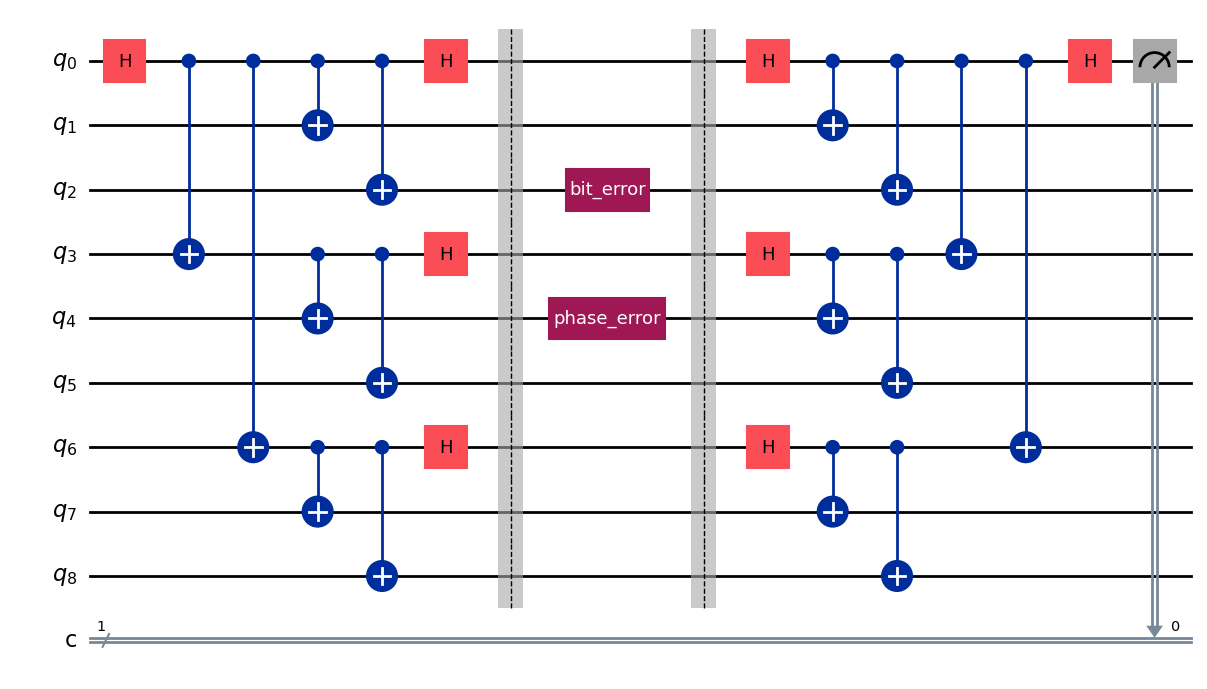

In [4]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def shors_encoding_circuit():
    qc = QuantumCircuit(9, name='Encoding')
    qc.h(0)
    qc.cx(0, 3)
    qc.cx(0, 6)
    for i in range(3):
        qc.cx(i*3, i*3 + 1)
        qc.cx(i*3, i*3 + 2)
    qc.h([0, 3, 6])
    return qc

def shors_decoding_circuit():
    qc = QuantumCircuit(9, name='Decoding')
    qc.h([0, 3, 6])
    # Measure syndromes and correct errors
    for i in range(3):
        qc.cx(i*3, i*3 + 1)
        qc.cx(i*3, i*3 + 2)    
    qc.cx(0, 3)
    qc.cx(0, 6)
    qc.h(0)
    return qc

# Function to create the full Shor's error correction circuit.
def shors_error_correction_circuit(bit_error_gate=None, phase_error_gate=None, 
                                   bit_error_qubit=None, phase_error_qubit=None):
    qc = QuantumCircuit(9, 1)
    qc.compose(shors_encoding_circuit(), inplace=True)
    qc.barrier()
    # Introduce one bit and one phase error.
    if bit_error_gate and bit_error_qubit is not None:
        qc.append(bit_error_gate, [bit_error_qubit])
    if phase_error_gate and phase_error_qubit is not None:
        qc.append(phase_error_gate, [phase_error_qubit])    
    qc.barrier()
    qc.compose(shors_decoding_circuit(), inplace=True)
    # Measure on wire 0 and send the result to classical register.
    qc.measure(0, 0)    
    return qc

# Select random qubit indices to apply the bit error and phase error
bit_error_qubit = np.random.choice(a=range(9))
phase_error_qubit = np.random.choice(a=range(9))

# Define an error gate (Pauli-X error) and name it "bit_error"
bit_error_gate = QuantumCircuit(1, name="bit_error")
bit_error_gate.x(0)
bit_error_gate = bit_error_gate.to_instruction()

# Define a phase error gate (Pauli-Z error) and name it "phase_error".
phase_error_gate = QuantumCircuit(1, name="phase_error")
phase_error_gate.z(0)
phase_error_gate = phase_error_gate.to_instruction()

# Create the full Shor's error correction circuit with a bit error and a phase error.
shors_circuit = shors_error_correction_circuit(
    bit_error_gate=bit_error_gate,
    phase_error_gate=phase_error_gate,
    bit_error_qubit=bit_error_qubit,
    phase_error_qubit=phase_error_qubit
)

# Draw the circuit.
shors_circuit.draw(output='mpl')


# Visualize in and out vectors. 

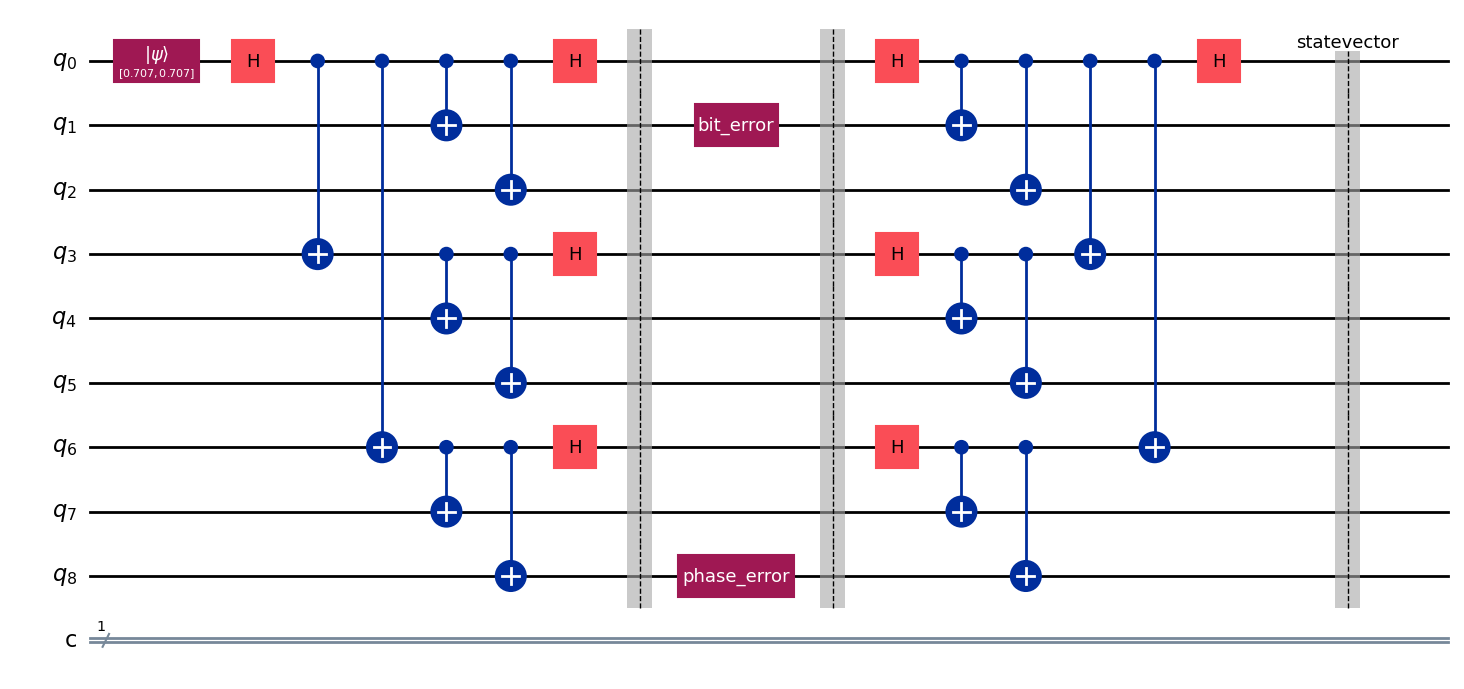

In [10]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import partial_trace, Statevector
from qiskit.visualization import plot_state_city
import matplotlib.pyplot as plt

# Function to create Shor's encoding circuit.
def shors_encoding_circuit():
    qc = QuantumCircuit(9, name='Encoding')
    
    # Encode the logical qubit.
    qc.h(0)
    qc.cx(0, 3)
    qc.cx(0, 6)
    
    for i in range(3):
        qc.cx(i*3, i*3 + 1)
        qc.cx(i*3, i*3 + 2)
    
    # Apply Hadamard gates to handle phase flip errors.
    qc.h([0, 3, 6])
    
    return qc

# Function to create Shor's decoding circuit.
def shors_decoding_circuit():
    qc = QuantumCircuit(9, name='Decoding')
    
    # Apply Hadamard gates to handle phase flip errors.
    qc.h([0, 3, 6])
    
    # Measure syndromes and correct errors.
    for i in range(3):
        qc.cx(i*3, i*3 + 1)
        qc.cx(i*3, i*3 + 2)
    
    qc.cx(0, 3)
    qc.cx(0, 6)
    qc.h(0)
    
    return qc

# Function to create the full Shor's error correction circuit.
def shors_error_correction_circuit(bit_error_gate=None, phase_error_gate=None, bit_error_qubit=None, phase_error_qubit=None):
    qc = QuantumCircuit(9, 1)
    
    # Encoding part.
    qc.compose(shors_encoding_circuit(), inplace=True)
    
    # Add barrier after encoding.
    qc.barrier()
    
    # Introduce bit error on the specified random qubit.
    if bit_error_gate and bit_error_qubit is not None:
        qc.append(bit_error_gate, [bit_error_qubit])
    
    # Introduce phase error on the specified random qubit.
    if phase_error_gate and phase_error_qubit is not None:
        qc.append(phase_error_gate, [phase_error_qubit])
    
    # Add barrier after errors.
    qc.barrier()
    
    # Decoding part.
    qc.compose(shors_decoding_circuit(), inplace=True)
    
    # Save the statevector at the end of the circuit.
    qc.save_statevector(label="statevector")
    
    return qc

# Select random qubit indices to apply the bit error and phase error.
bit_error_qubit = np.random.choice(a=range(9))
phase_error_qubit = np.random.choice(a=range(9))

# Define an error gate (Pauli-X error) and name it "bit_error".
bit_error_gate = QuantumCircuit(1, name="bit_error")
bit_error_gate.x(0)
bit_error_gate = bit_error_gate.to_instruction()

# Define a phase error gate (Pauli-Z error) and name it "phase_error".
phase_error_gate = QuantumCircuit(1, name="phase_error")
phase_error_gate.z(0)
phase_error_gate = phase_error_gate.to_instruction()

# Create the full Shor's error correction circuit with a bit error and a phase error.
shors_circuit = shors_error_correction_circuit(
    bit_error_gate=bit_error_gate,
    phase_error_gate=phase_error_gate,
    bit_error_qubit=bit_error_qubit,
    phase_error_qubit=phase_error_qubit
)

# Define the initial state for the 0th qubit.
initial_state = [1/np.sqrt(2), 1/np.sqrt(2)]  # Example: |+> state

# Create the initial state preparation circuit.
init_circuit = QuantumCircuit(9)
init_circuit.initialize(initial_state, 0)

# Combine the initial state preparation circuit with the Shor's circuit.
full_circuit = init_circuit.compose(shors_circuit)

# Draw the full circuit.
full_circuit.draw(output='mpl')

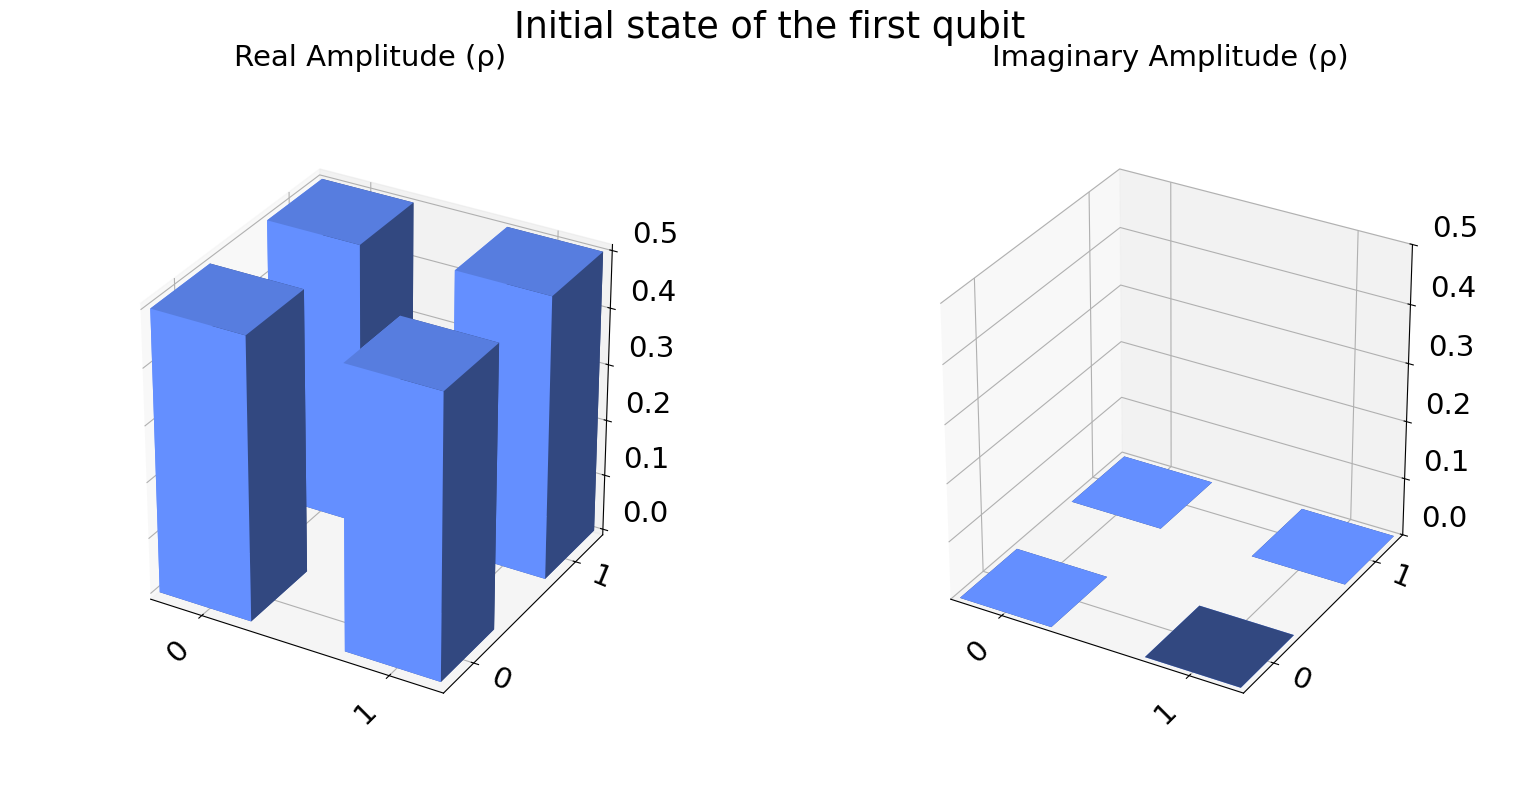

In [11]:
from qiskit_aer import AerSimulator 
from qiskit import transpile

# Use the AerSimulator for statevector simulation.
simulator = AerSimulator(method="statevector")

# Transpile the circuit for the simulator.
transpiled_circ = transpile(full_circuit, simulator)

# Run the simulation.
result = simulator.run(transpiled_circ).result()

# Get the statevector from the result.
statevector = result.data()['statevector']

# Convert the statevector to a Statevector object.
statevector = Statevector(statevector)

# Reduce the statevector to the first qubit.
initial_statevector = Statevector(initial_state)
reduced_state_initial = partial_trace(initial_statevector.tensor(Statevector.from_label('0'*8)), range(1, 9))
reduced_state_final = partial_trace(statevector, range(1, 9))

# # Visualize the initial and final statevectors using the state city plot.
# fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Set the current axes and plot the initial state.
# plt.sca(axes[0])
# plt.ylim(0,1)
plot_state_city(initial_state,  title='Initial state of the first qubit')

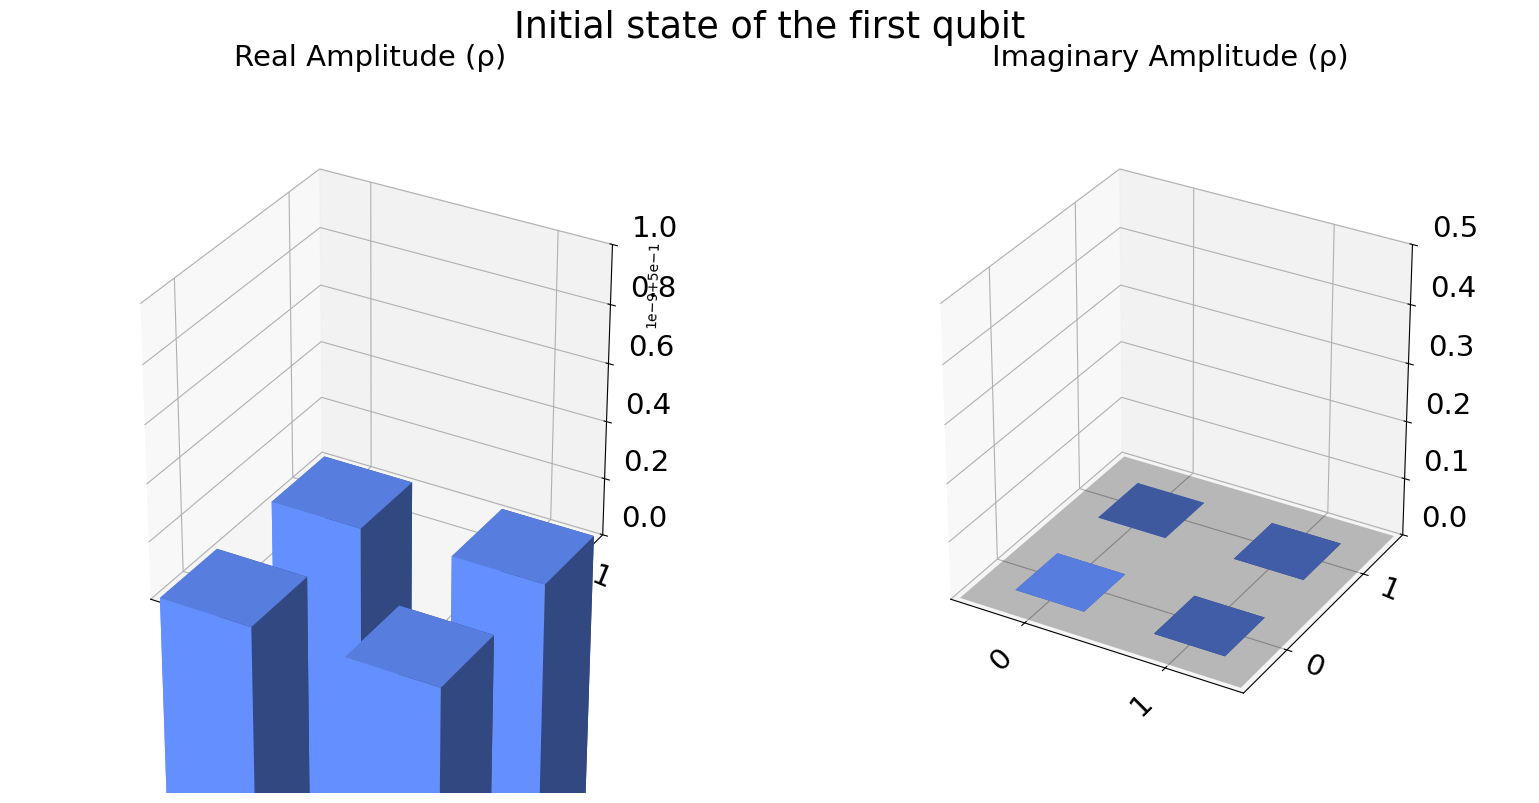

In [12]:
plot_state_city(reduced_state_final,  title='Initial state of the first qubit')

# Shor module

In this section, I will create a module that facilitates 
- taking in a sequence of length $n_{qubits}$ of one qubit state vectors
- Shor encoding
- applying a series of gates that is the identity except for quantum noise
- shor decoding

to evaluate the ability of the Shor algorithm to correct the errors from quantum noise. 

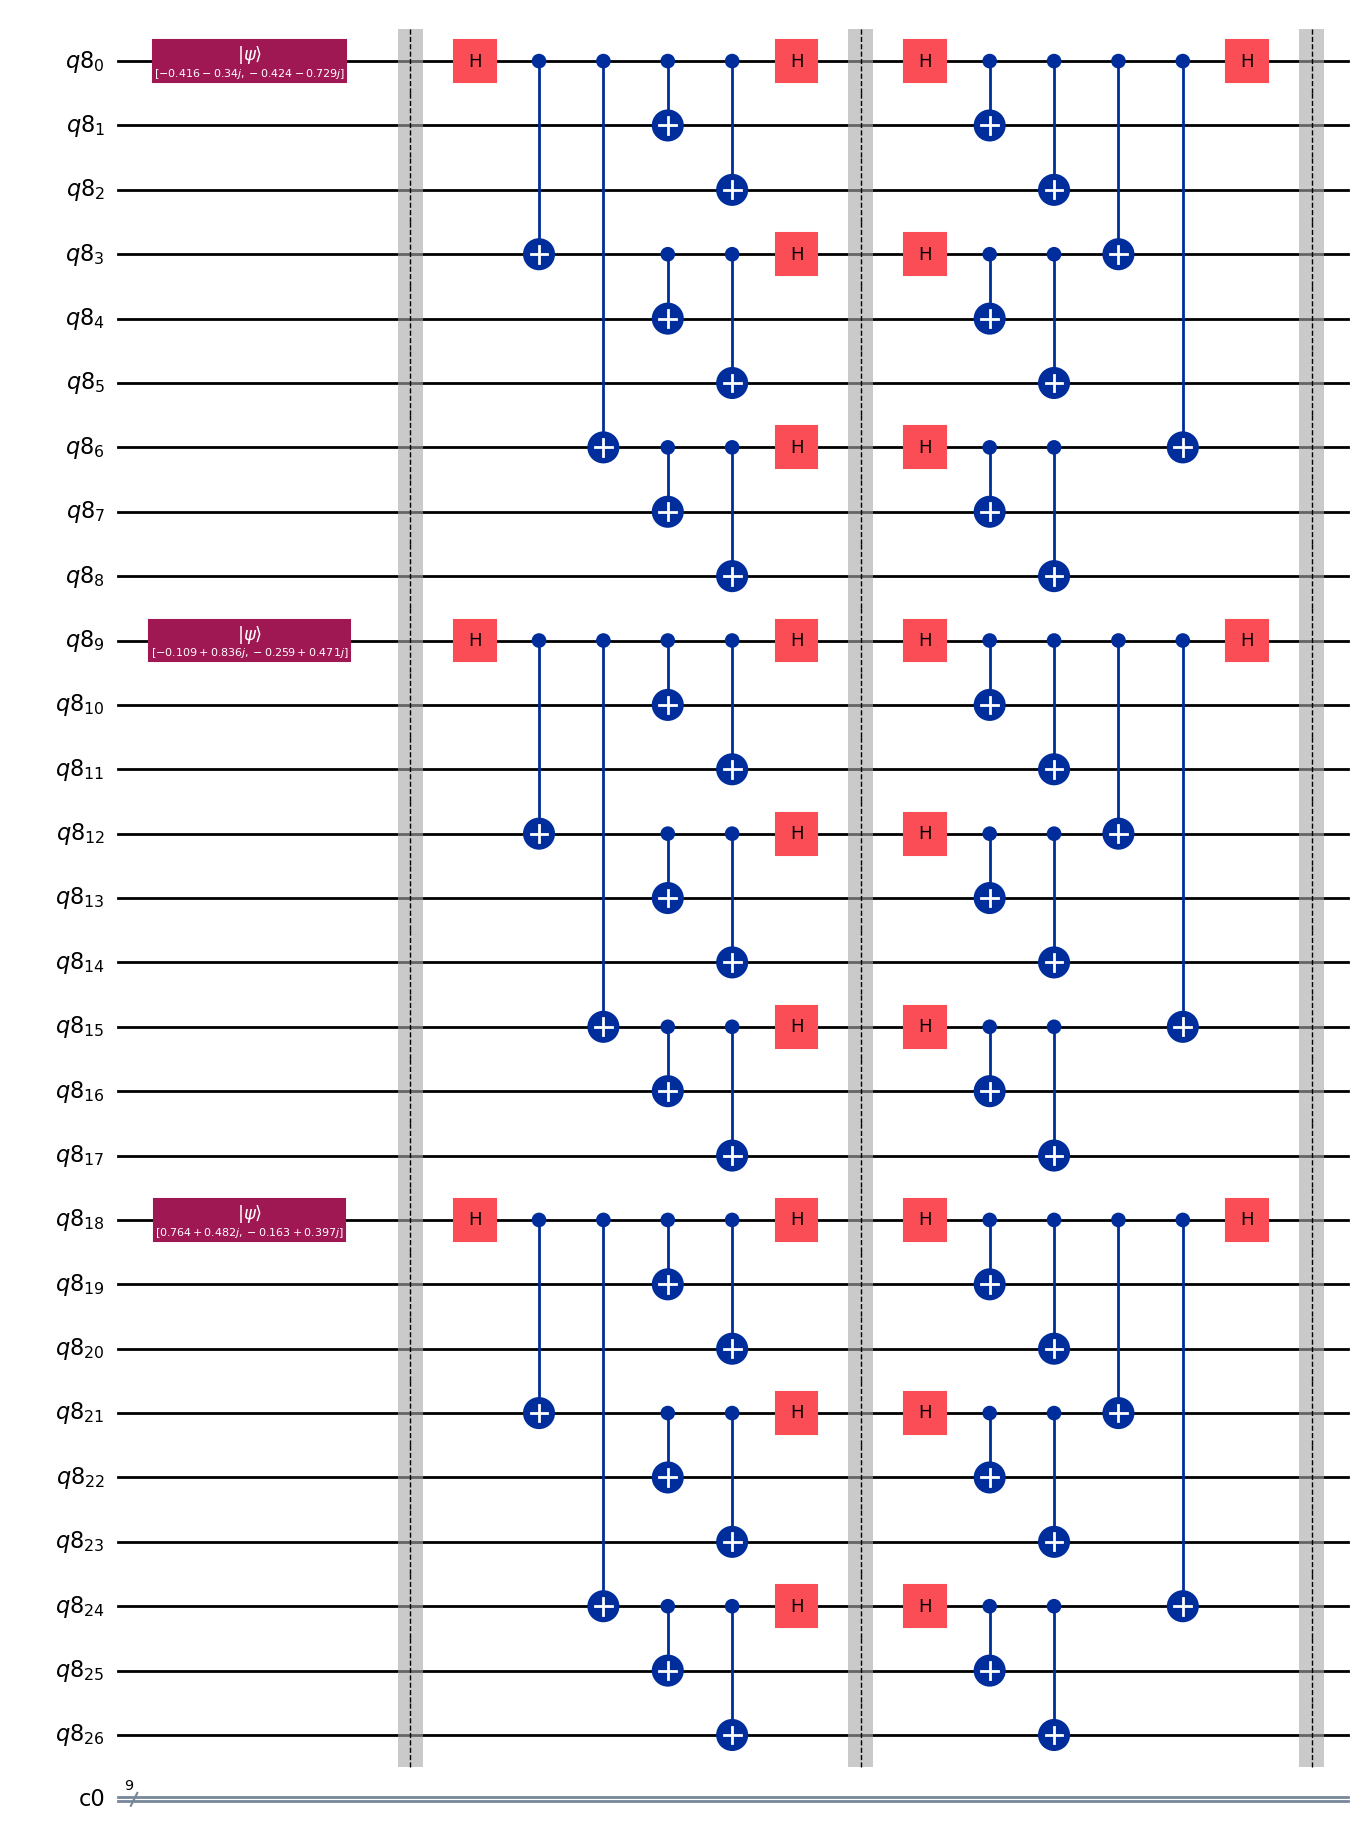

In [13]:
from utils import generate_random_states
from shor import shor_encode, shor_decode


# Example usage
n_qubits = 3
random_states = generate_random_states(n_qubits)
initial_circuit = shor_encode(n_qubits=n_qubits, state_vectors=random_states)
decoding_circuit = shor_decode(n_qubits=n_qubits)
complete_circuit = initial_circuit.compose(decoding_circuit)
complete_circuit.draw("mpl")


## Comparing input and output states

In [14]:
import numpy as np
from utils import generate_random_states, trace_over_ancilla_qubits
from shor import shor_encode, shor_decode
from qiskit.quantum_info import Statevector, DensityMatrix, state_fidelity
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_state_city

# Example usage
n_qubits = 2
random_states = generate_random_states(n_qubits)
initial_combined_state = np.kron(*[state.data for state in random_states])
initial_state_vector = Statevector(initial_combined_state)
initial_state_density = DensityMatrix(initial_state_vector)

initial_circuit = shor_encode(n_qubits=n_qubits, state_vectors=random_states)
decoding_circuit = shor_decode(n_qubits=n_qubits)

# Concatenate the encoding and decoding circuits
complete_circuit = initial_circuit.compose(decoding_circuit)

# Simulate the complete circuit to get the final statevector
simulator = AerSimulator()
complete_circuit.save_statevector()
result = simulator.run(complete_circuit).result()
final_state_vector = result.get_statevector()

In [15]:
reduced_final_state_density = trace_over_ancilla_qubits(final_state_vector, n_qubits)

In [16]:
state_fidelity(initial_state_density, reduced_final_state_density)

0.3105665141325908

## State fidelity should be 1

There is no error or noise introduced at this point. 

In [ ]:
# My kernel dies on this... Presumably checking if this transformation is possible. 
# final_state_density = DensityMatrix(final_state_vector)

Fidelity between states $\rho_1,\rho_2$ is the quantity $F(\rho_1, \rho_2) = Tr[\sqrt{\sqrt{\rho_1}\rho_2\sqrt{\rho_1}}]^2.$ I do not know the reason for the definition. 

### Checking that the vectors are not botched

They were. In particular, vector to density to vector is not the identity map because density to vector is unique op to a phase for pure states.

In [5]:
from qiskit.quantum_info import random_statevector, Statevector, DensityMatrix

vector = random_statevector(2)
density = DensityMatrix(vector)
final_vector = density.to_statevector()

np.allclose(vector, final_vector)

False

But, there is just a change of phase. 

In [165]:
np.abs(np.dot(vector.data.conj(), final_vector.data))

0.9999999999999999

So, I really need to compare the initial and final density, not the vectors, since there is phase ambiguity in the latter. 

# Fault tolerant Trotterized transverse ising model

Let  $\sigma^{(j)}_z$ acts only on the $j$th tensor factor and recall that 
$$
\sigma_z \vert i \rangle = (-1)^i \vert i \rangle ,~ i =0,1 \,.
$$

**Definition:** A <u>transverse quantum ising model</u> is an $n$ qubit register together with a graph $(V,E)$ and Hamiltonian 
$$
{\cal H}_P = \sum\limits_{i\in V} \theta_{ii} {\color{blue}{\sigma^{(i)}_x }}
    + \sum\limits_{\{i,j\}\in E}\theta_{ij}\sigma^{(j)}_z \sigma^{(j)}_z \,.
$$

The blue term is what makes this a transverse model; the magnetic field is perpendicular to the interaction between the vertices. We will examine the case where the magnetic field is constant so $\theta_{ii} = h$ and the interaction strength is constant so $\theta_{ij} = J$.


In general, if $H = \sum_i H_i$ then $e^{-iH\Delta t} = \prod_i e^{ -i H_i \Delta t}$ up to first order in $\Delta t$. 

**Definition:** The <u>first order Trotter decomposition</u> of $e^{-i H \Delta t}$ where  is $\prod_i e^{ -i H_i \Delta t}$.

aka Trotterization.

The idea is that the terms $H_i$ may not commute, so calculation of the exponentiation is hard, but easy to approximate over small time intervals. Letting $n=T /\Delta t$ the full time evolution is approximated by $e^{-iHt} \approx \big(\prod_i e^{ -i H_i \Delta t}\big)^n$.


In the case of the transverse ising model, the Hamiltonian has two terms 

$$
H = H_{X}+ H_{ZZ} = \sum_i h X_i  - \sum_{ij} J Z_i Z_j
$$
and since
$$
\begin{align}
e^{-iH_X \Delta t} \approx \prod_i e^{ -i h X_i \Delta t} =: \prod_{i\in V}  R_{X_i}(2h\Delta t)\, , 
\\
e^{-iH_{ZZ} \Delta t } \approx \prod_{ij} e^{+ iJ Z_i Z_j \Delta t}=: \prod_{\{i,j\} \in E} R_{Z_i,Z_j}(-2J\Delta t)
\end{align}
$$
where the arguments at the end are interpreted as angles because $R_X$ and $R_{ZZ}$ are unitary operators
$$
e^{-iH \Delta t} \approx 
\prod_{i\in V}R_{X_i}(2h\Delta t)\prod_{\{i,j\} \in E} R_{Z_i,Z_j}(-2J\Delta t) \,.
$$

In first order trotterization the order of the factors does not matter; the factors can be permuted without consequence. We will make use of this.

Application of $n$ trotter steps is then application of 
$$
\left(\prod_{i\in V}R_{X_i}(2h\,n\Delta t)\prod_{\{i,j\} \in E} R_{Z_i,Z_j}(-2J n \Delta t) \right)
\approx  e^{iH \,n\Delta t} 
$$
giving approximate time evolution over the interval of $t$ values $[0,n\Delta t]$. 

The factors can be expressed in terms of 1-qubit and 2-qubit quantum gates, as in the diagram below. 

We will examine a one dimensional ising model with vertices $V = \{1,...,n\}$ and edges $E = \{ \{1,2\},\{2,3\},\{3,4 \}, \{ 4,5 \}, \{5,6\},...,\{n-1,n\}\}$. Edges will be alternately colored red and green:
- the "even edges" $\{  \{1,2\},\{3,4\}, ...\}$ are red, 
- the "odd edges" $\{ \{2,3\},\{4,5\},...\}$ are green.

We take advantage of the permutation invariance of the trotterization by applying gates in the following order
1. $R_{ZZ}$ to the even edges
2. $R_{ZZ}$ to the odd edges
3. $R_X$ to all vertices. 

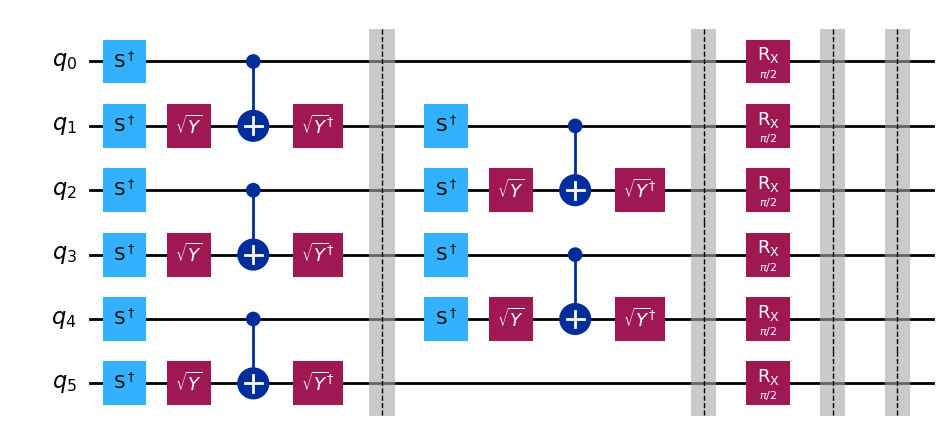

In [20]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate # latter allows creation of new unitary gates
import numpy as np

# Defne the square root of Y gate and square root of Y dagger gate in terms of YGate.
SYGate = UnitaryGate(YGate().power(1/2), label=r"$\sqrt{Y}$")
SYdgGate = UnitaryGate(SYGate.inverse(), label=r"$\sqrt{Y}^\dag$")

def generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, 
                             num_cl_bits=0, # Classical bits are used to report measurements
                             trotter_barriers = False, # Draw a vertical line between trotter steps.
                             layer_barriers = False # Draw a vertical line between Layers in the 2-qubit layering of 2-qubit depth
                            ):
    '''tfim means Transverse field ising model'''
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, 
                            num_cl_bits # These are where measurements will go.
                           )

    for trotter_step in range(num_trotter_steps):
        add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:
            # 
            qc.barrier()
    
    return qc

def add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
    # Apply Rzz in the red/even layer
    for i in range(0, qc.num_qubits-1, 2): # note that is every other index
        # Apply gates as in the diagram:
        qc.sdg([i, i+1]) # sdg is s dagger 
        qc.append(SYGate, [i+1]) # SYGate appears to be a name for square root of Y
        qc.cx(i, i+1) # controlled swap
        qc.append(SYdgGate, [i+1]) # square root of Y dagger
    if layer_barriers:
        # In the diagram we will draw, put all gates applied so far to the left of a barrier
        # and everything that follows to the right of the barrier. 
        qc.barrier() 
    # Apply Rzz in the green/odd layers
    for i in range(1, qc.num_qubits-1, 2): #start at 1 not at 0
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
    if layer_barriers:
        qc.barrier()
    # Apply Rx in all vertices
    qc.rx(rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()

num_qubits = 6
num_trotter_steps = 1
rx_angle = 0.5 * np.pi

qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, 
                              trotter_barriers=True, 
                              layer_barriers=True)
qc.draw(output='mpl', # mpl is pretty
        fold=-1)

# Reverse time evolution

In [21]:
def append_mirrored_1d_tfim_circuit(
    qc, num_qubits, num_trotter_steps, rx_angle, 
    trotter_barriers = False, layer_barriers = False
    ):
    for trotter_step in range(num_trotter_steps):
        add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()

def add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
    # Note after filming:
    # I constructed the inverse by hand here
    # But you could also use QuantumCircuit.inverse() to do this more efficiently
    # R_x first
    qc.rx(-rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()
    # Adding Rzz in the odd/green layers second
    for i in range(1, qc.num_qubits-1, 2):
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
        qc.s([i, i+1])
    if layer_barriers:
        qc.barrier()
    # Adding Rzz in the even/red layers last
    for i in range(0, qc.num_qubits-1, 2):
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
        qc.s([i, i+1])
    if layer_barriers:
        qc.barrier()

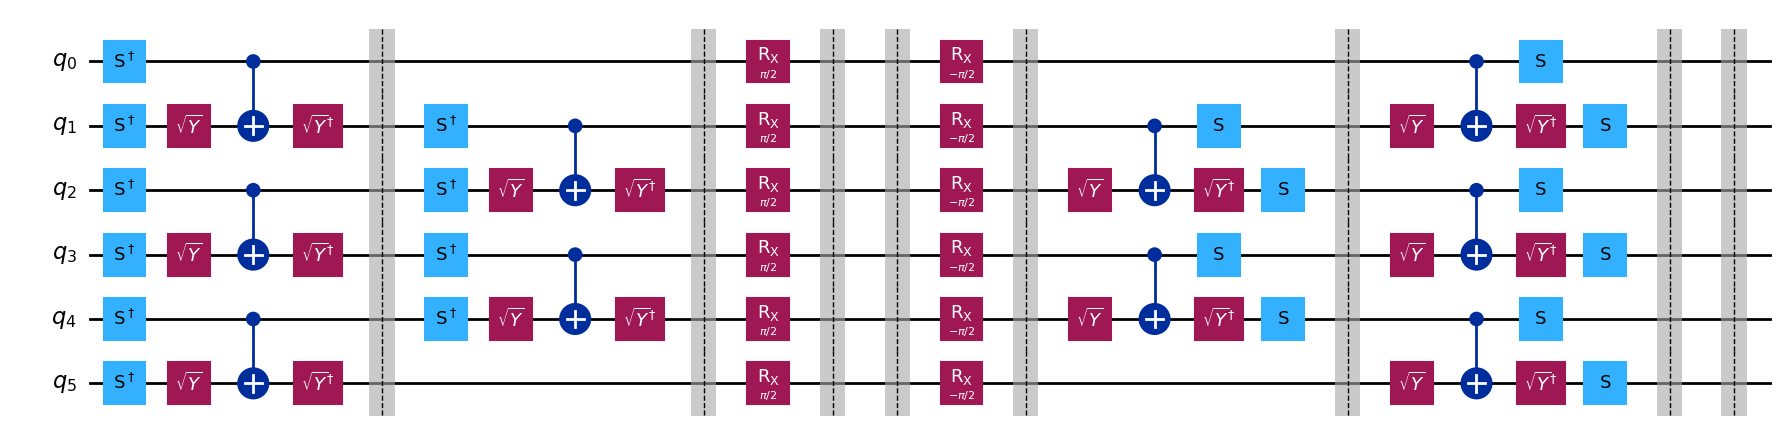

In [22]:
append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, 
                                trotter_barriers=True, layer_barriers=True)
qc.draw(output='mpl', fold=-1)
# This sould work out to the identity function. 

In [31]:
max_trotter_steps = 10
num_qubits = 6
middle_qubit = num_qubits // 2
measured_qubits = [middle_qubit,middle_qubit+1] # measure "survivability" of the middle qubits 

qc_list = []
for trotter_steps in range(max_trotter_steps):
    qc = generate_1d_tfim_circuit(
        num_qubits=num_qubits, 
        num_trotter_steps=trotter_steps, # his mistake
        rx_angle=rx_angle, 
        num_cl_bits=len(measured_qubits), # One classical bit for each "middle qubit"
        trotter_barriers=True, layer_barriers=True
    )
    append_mirrored_1d_tfim_circuit(
        qc, 
        num_qubits, 
        num_trotter_steps = trotter_steps, 
        rx_angle=rx_angle, 
        trotter_barriers=True, layer_barriers=True)
    qc.measure(measured_qubits, 
               list(range(len(measured_qubits)))# measurements sent to classical registers 0,1...
              )
    qc_list.append(qc)

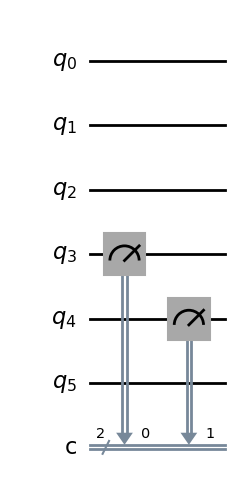

In [32]:
qc_list[0].draw(output='mpl', fold=-1)

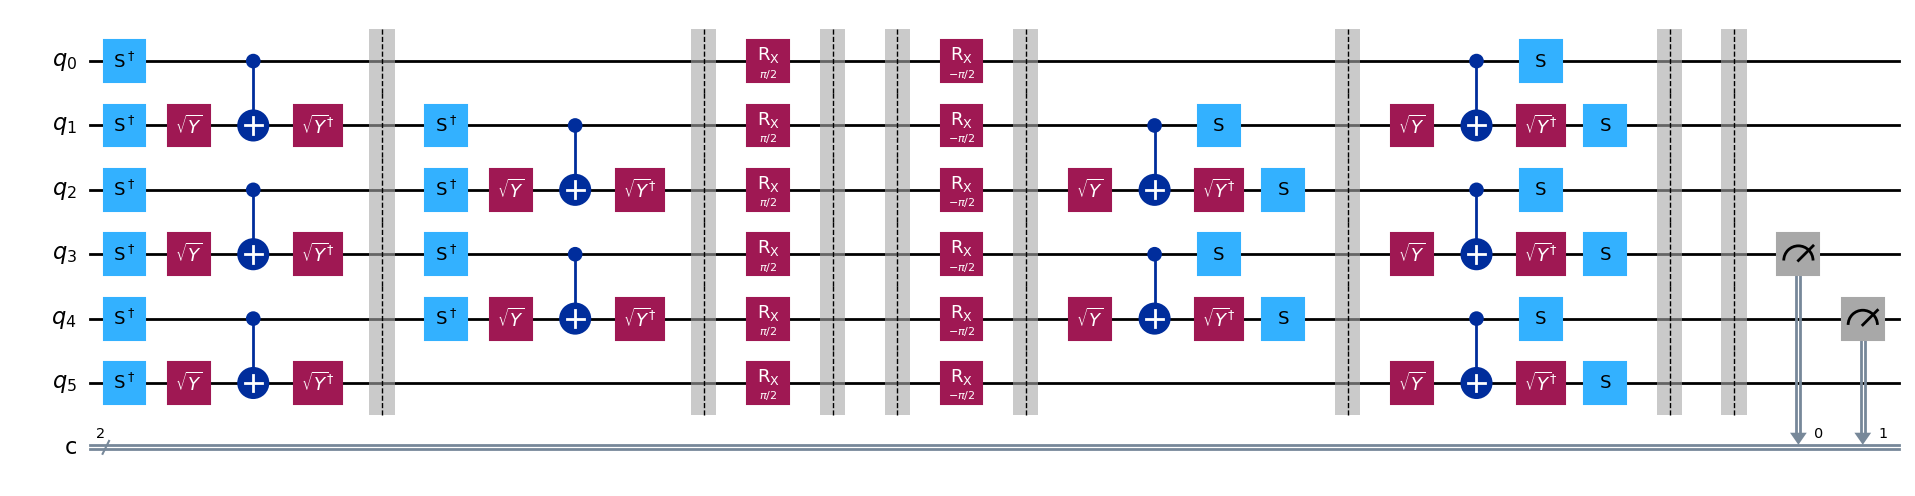

In [33]:
qc_list[1].draw(output='mpl', fold=-1)

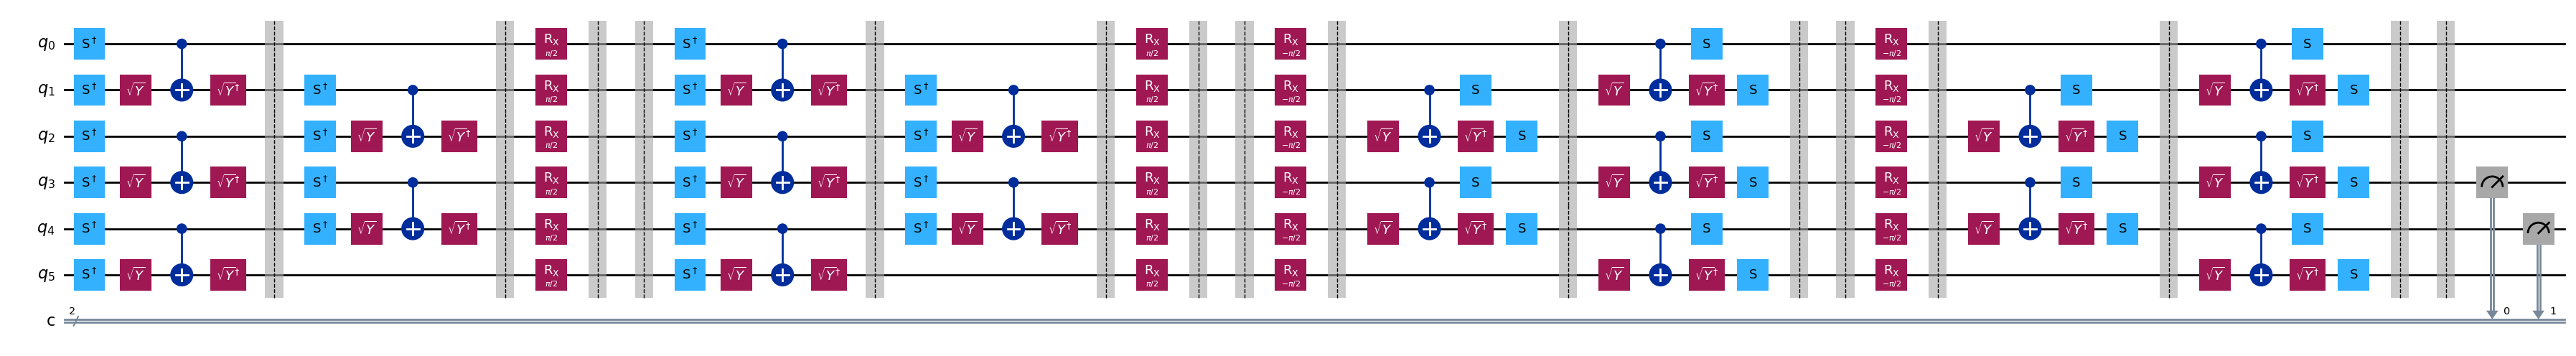

In [34]:
qc_list[2].draw(output='mpl', fold=-1)

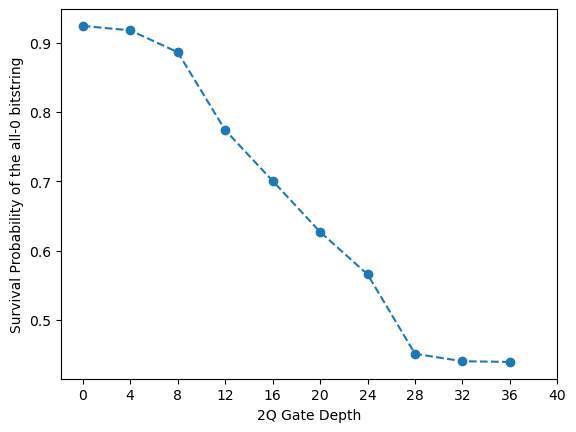

In [33]:
import matplotlib.pyplot as plt

# Every trotter step has a two qubit depth of 4.... what? 
plt.plot(list(range(0, 4 * max_trotter_steps, 4)), survival_probability_list, '--o')
plt.xlabel('2Q Gate Depth')
plt.ylabel('Survival Probability of the all-0 bitstring')
plt.xticks(np.arange(0, 44, 4))
plt.show()